In [1]:
import torch
from torch.autograd import Variable
import numpy as np
import torch.nn.functional as F
import torchvision
from torchvision import transforms
import torch.optim as optim
from torch import nn
import matplotlib.pyplot as plt

In [2]:
class VAE(nn.Module):
  
    def __init__(self):
        super(VAE, self).__init__()
        
        self.conv1 = nn.Conv2d(1, 32, 3)
        self.conv2 = nn.Conv2d(32, 16, 3)
        self.max_pool = nn.MaxPool2d(kernel_size = 2, stride = 2)
        self.fc1_mu = nn.Linear(12 * 12 * 16, 20)
        self.fc1_sig = nn.Linear(12 * 12 * 16, 20)
        self.fc2 = nn.Linear(20, 12 * 12 * 16)
        self.up_sample = nn.UpsamplingNearest2d(scale_factor=2)
        self.conv3 = nn.ConvTranspose2d(16, 32, 3)
        self.conv4 = nn.ConvTranspose2d(32, 1, 3)
  
    def encode(self,x):
        a1 = F.relu(self.conv1(x))
        a2 = F.relu(self.conv2(a1))
        mx_poold = self.max_pool(a2)
        a_reshaped = mx_poold.reshape(-1 , 12 * 12 * 16)
        a_mu = self.fc1_mu(a_reshaped)
        a_logvar = self.fc1_sig(a_reshaped)
        return a_mu, a_logvar
  
    def decode(self,z):
        a3 = F.relu(self.fc2(z))
        a3 = a3.reshape(-1, 16, 12, 12)
        a3_upsample = self.up_sample(a3)
        a4 = F.relu(self.conv3(a3_upsample))
        a5 = torch.sigmoid(self.conv4(a4))
        return a5
  
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mu)
  
    def forward(self,x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar
    

In [3]:
train_dataset = torchvision.datasets.MNIST(root='./data',train=True, transform=transforms.ToTensor(), download=True)
test_dataset = torchvision.datasets.MNIST(root='./data',train=False, transform=transforms.ToTensor(),download = True)
batch_size = 100
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=100, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,  batch_size=100, shuffle=False)

In [4]:
model = VAE()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [5]:
def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')

    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + KLD

In [6]:
num_epochs = 3
print_per = 100
model.train()
for epoch in range(num_epochs):
    train_loss = 0
    print_loss = 0
    loss_record = []
    for i, (images, _) in enumerate(train_loader):
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(images)
        loss = loss_function(recon_batch, images, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        print_loss += loss.item()
        optimizer.step()
        if (i%print_per == 0):
            print("Epoch : {} , Minibatch : {} Loss = {:.4f}".format(epoch, i, print_loss))
            loss_record.append(print_loss)
            print_loss = 0
    print("Epoch {} : Loss = ({:.4f}) ".format(epoch, train_loss))

/Users/ashutoshchaubey/anaconda3/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:177: UserWarning: nn.UpsamplingNearest2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.UpsamplingNearest2d is deprecated. Use nn.functional.interpolate instead.")
/Users/ashutoshchaubey/anaconda3/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")
/Users/ashutoshchaubey/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1594: UserWarning: Using a target size (torch.Size([100, 784])) that is different to the input size (torch.Size([100, 1, 28, 28])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


Epoch : 0 , Minibatch : 0 Loss = 56012.6289
Epoch : 0 , Minibatch : 100 Loss = 2915919.6895
Epoch : 0 , Minibatch : 200 Loss = 1833104.8945
Epoch : 0 , Minibatch : 300 Loss = 1450434.5146
Epoch : 0 , Minibatch : 400 Loss = 1314923.4404
Epoch : 0 , Minibatch : 500 Loss = 1247527.1338
Epoch 0 : Loss = (10019173.3564) 
Epoch : 1 , Minibatch : 0 Loss = 11614.5244
Epoch : 1 , Minibatch : 100 Loss = 1185920.8916
Epoch : 1 , Minibatch : 200 Loss = 1177063.2881
Epoch : 1 , Minibatch : 300 Loss = 1157446.2979
Epoch : 1 , Minibatch : 400 Loss = 1150543.3818
Epoch : 1 , Minibatch : 500 Loss = 1134763.0400
Epoch 1 : Loss = (6943046.3438) 
Epoch : 2 , Minibatch : 0 Loss = 11679.6680
Epoch : 2 , Minibatch : 100 Loss = 1123419.2793
Epoch : 2 , Minibatch : 200 Loss = 1116964.3379
Epoch : 2 , Minibatch : 300 Loss = 1112862.6631
Epoch : 2 , Minibatch : 400 Loss = 1104174.3564
Epoch : 2 , Minibatch : 500 Loss = 1105957.5645
Epoch 2 : Loss = (6663304.8271) 


(1, 28, 28)
torch.Size([1, 1, 28, 28])


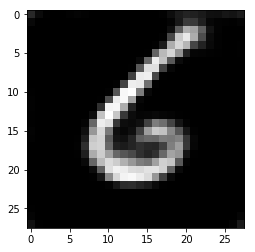

In [16]:
print(model(images)[0].data[0].numpy().shape)
image1 = images[8].reshape(1, 1, 28, 28)
print(image1.shape)
plt.imshow(model(images)[0].data[8].numpy().reshape(28, 28), cmap='gray')
plt.show(block=True)

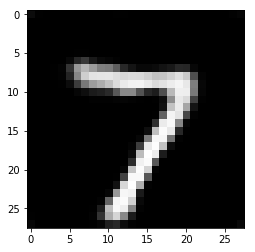

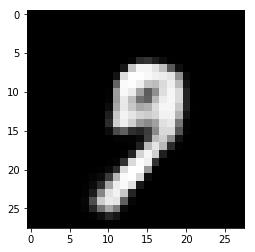

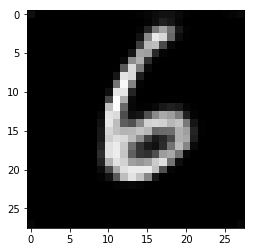

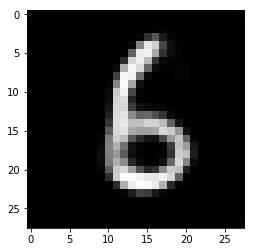

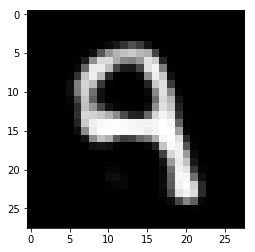

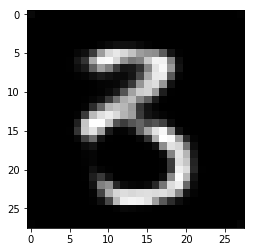

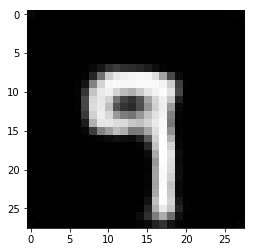

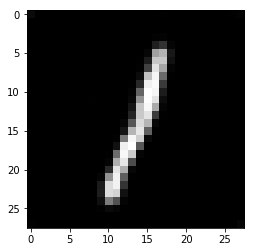

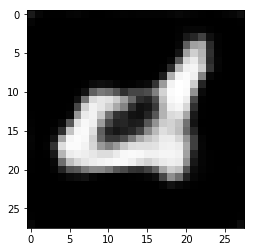

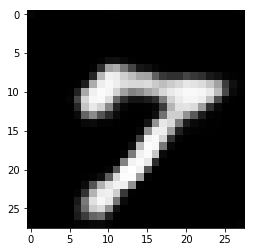

In [17]:
test_loss = 0
print_per = 10
with torch.no_grad():
    for i, (images, _) in enumerate(test_loader):
        recon_batch, mu, logvar = model(images)
        test_loss += loss_function(recon_batch, images, mu, logvar).item()
        if (i%print_per == 0):
            plt.imshow(model(images)[0].data[0].numpy().reshape(28, 28), cmap='gray')
            plt.show(block=True)

In [18]:
image2 = images[1].reshape(1, 1, 28, 28)
print(image2.shape)

torch.Size([1, 1, 28, 28])


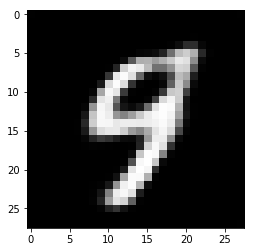

In [19]:
plt.imshow(model(images)[0].data[1].numpy().reshape(28, 28), cmap='gray')
plt.show(block=True)

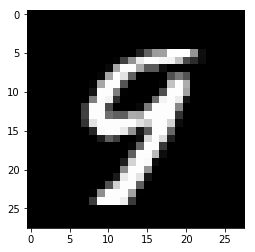

In [20]:
plt.imshow(images[1].numpy().reshape(28, 28), cmap='gray')
plt.show(block=True)

In [27]:
with torch.no_grad():
    mu1, logvar1 = model.encode(image1)
    std1 = torch.exp(0.5*logvar1)
    mu2, logvar2 = model.encode(image2)
    std2 = torch.exp(0.5*logvar2)
    print(mu1.shape)

torch.Size([1, 20])


In [22]:
with torch.no_grad():
    recon_images1 = []
    recon_images2 = []
    for ctr in range(0, 100, 5):
        eps_val = torch.full_like(mu1, fill_value = ctr * 0.01 )
        z_val1 = eps_val.mul(std1).add_(mu1)
        z_val2 = eps_val.mul(std2).add_(mu2)
        recon_image1 = model.decode(z_val1)
        recon_image2 = model.decode(z_val2)
        recon_images1.append(recon_image1)
        recon_images2.append(recon_image2)

In [23]:
print(recon_images1[0] - recon_images1[1])

tensor([[[[-8.5261e-04, -2.7074e-04, -2.2780e-05, -2.1208e-06,  9.8837e-08,
           -2.2026e-05, -1.1563e-04, -1.3727e-04, -6.2921e-05, -3.8676e-05,
           -2.7594e-05, -4.1555e-05, -6.2835e-05, -5.8390e-05, -5.9461e-05,
           -6.1746e-05, -1.0138e-04, -2.9930e-04, -1.0519e-03, -1.5257e-03,
           -1.6240e-03, -1.5401e-03, -9.6513e-04, -4.5336e-04, -2.6402e-04,
           -2.3903e-04, -1.3402e-04, -3.3899e-04],
          [-2.1533e-04, -6.7477e-06, -2.1258e-07, -1.1860e-08, -1.3469e-08,
           -9.4964e-07, -5.0364e-06, -3.4616e-06, -1.0281e-06, -5.2730e-07,
           -2.1195e-07, -5.1706e-07, -2.0497e-06, -2.0459e-06, -1.6854e-06,
           -1.7879e-06, -3.7285e-06, -4.4135e-05, -6.1437e-04, -1.6297e-03,
           -1.8794e-03, -1.5699e-03, -4.0504e-04, -5.7039e-05, -1.1199e-06,
           -9.3342e-06, -8.7770e-06, -3.8972e-05],
          [-3.9342e-05, -7.1976e-07, -7.2376e-08, -1.0104e-07, -1.9606e-07,
           -2.8519e-06, -3.0684e-06, -8.7167e-07, -4.0580e-07,

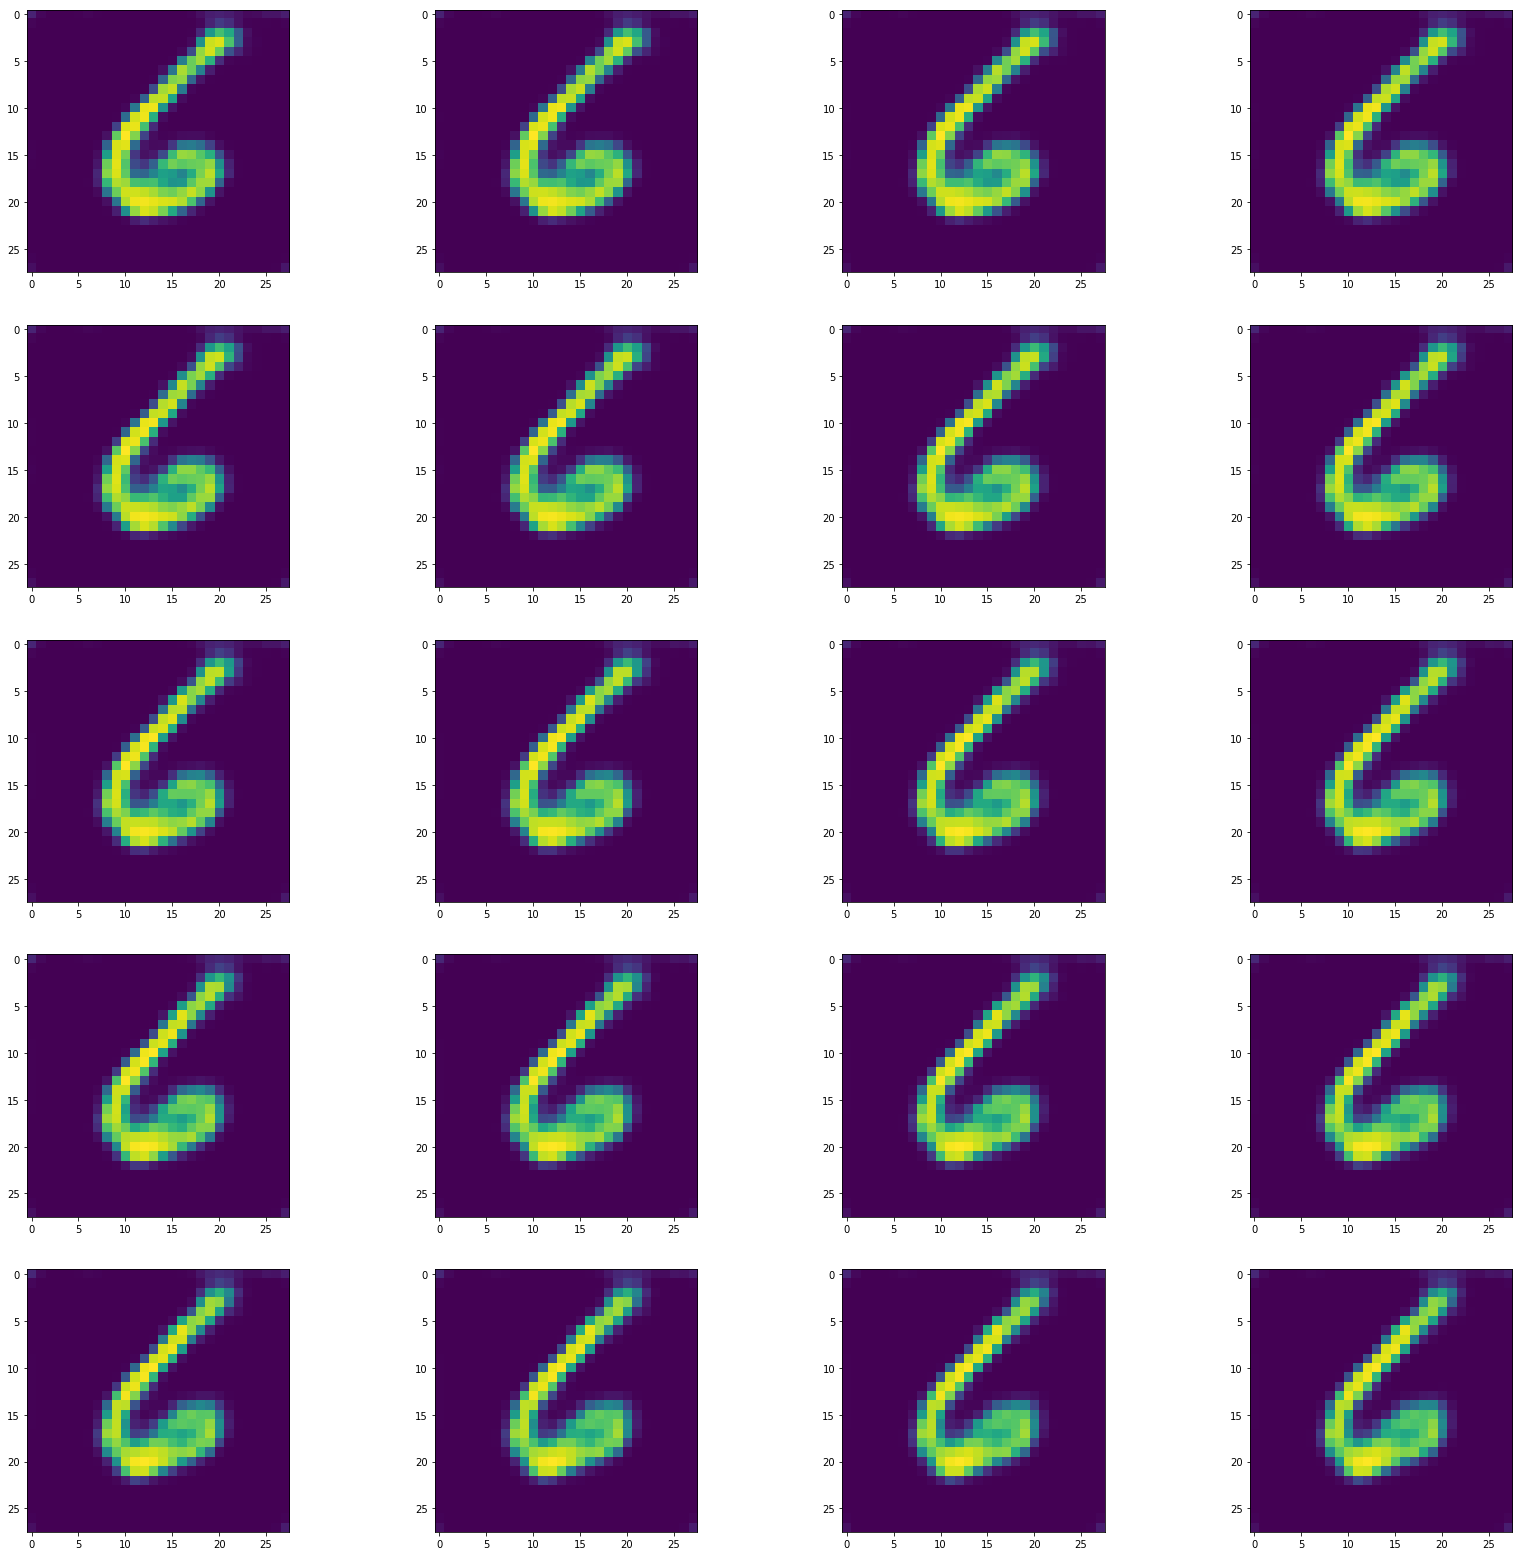

In [25]:
fig=plt.figure(figsize=(28, 28))
columns = 4
rows = 5
for i in range(1, columns*rows +1):
    img = recon_images1[i-1].detach().numpy().reshape(28, 28)
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
plt.show()

In [28]:
with torch.no_grad():
    recon_images1 = []
    recon_images2 = []
    eps_val = torch.randn_like(mu1)
    for ctr in range(0, 100, 5):
        eps_val[:, 7] = ctr * 0.05 * std1[:, 7] + mu1[:, 7]
        z_val1 = eps_val.mul(std1).add_(mu1)
        z_val2 = eps_val.mul(std2).add_(mu2)
        recon_image1 = model.decode(z_val1)
        recon_image2 = model.decode(z_val2)
        recon_images1.append(recon_image1)
        recon_images2.append(recon_image2)

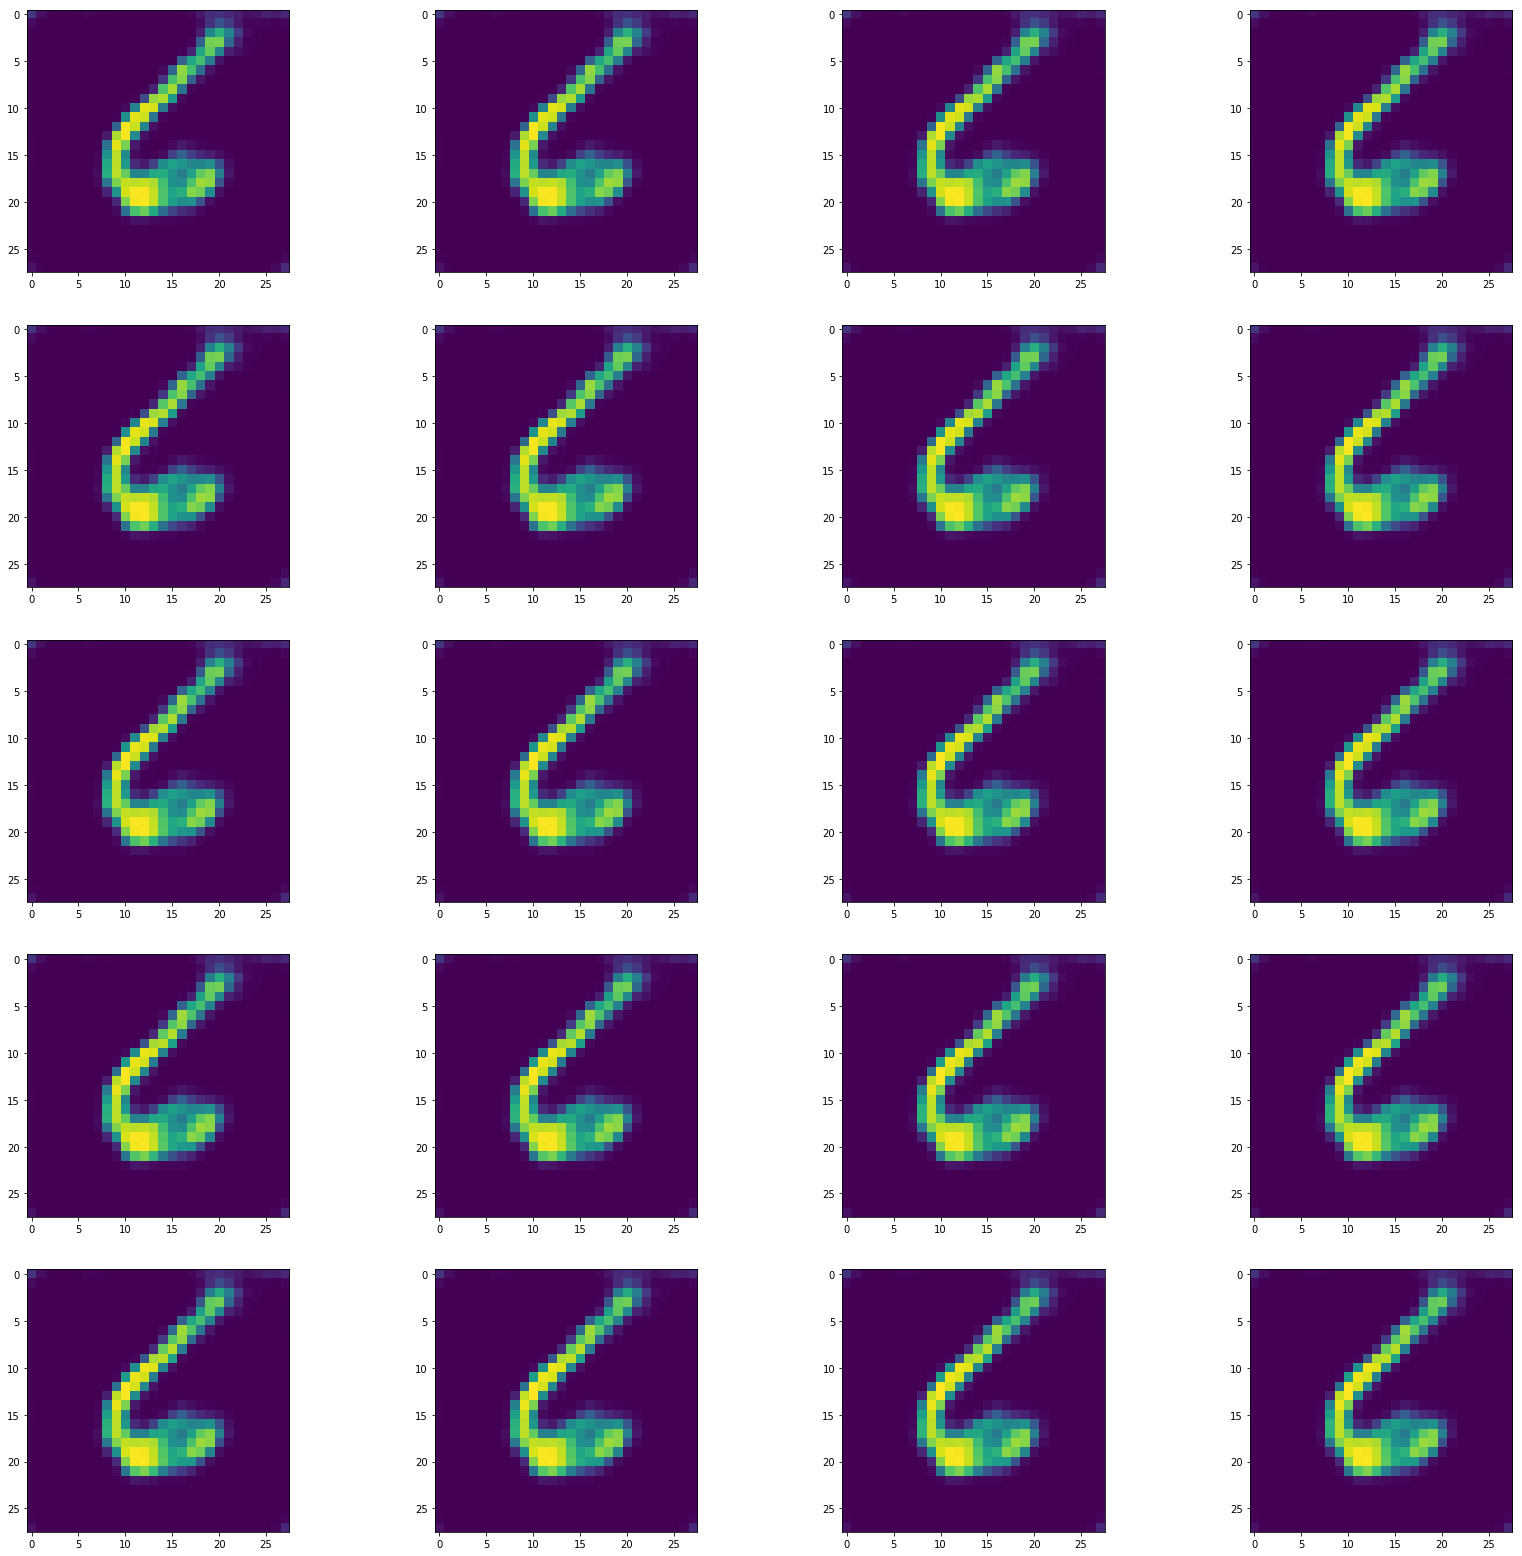

In [30]:
fig=plt.figure(figsize=(28, 28))
columns = 4
rows = 5
for i in range(1, columns*rows +1):
    img = recon_images1[i-1].detach().numpy().reshape(28, 28)
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
plt.show()

In [31]:
eps_any = torch.randn_like(mu1)
z1 = eps_any.mul(std1).add_(mu1)
z2 = eps_any.mul(std2).add_(mu2)
all_recons = []
for i in range(20):
    z_bet = z1 + torch.full_like(mu1, fill_value = 0.05*i).mul(z2 - z1)
    recon_image = model.decode(z_bet)
    all_recons.append(recon_image)

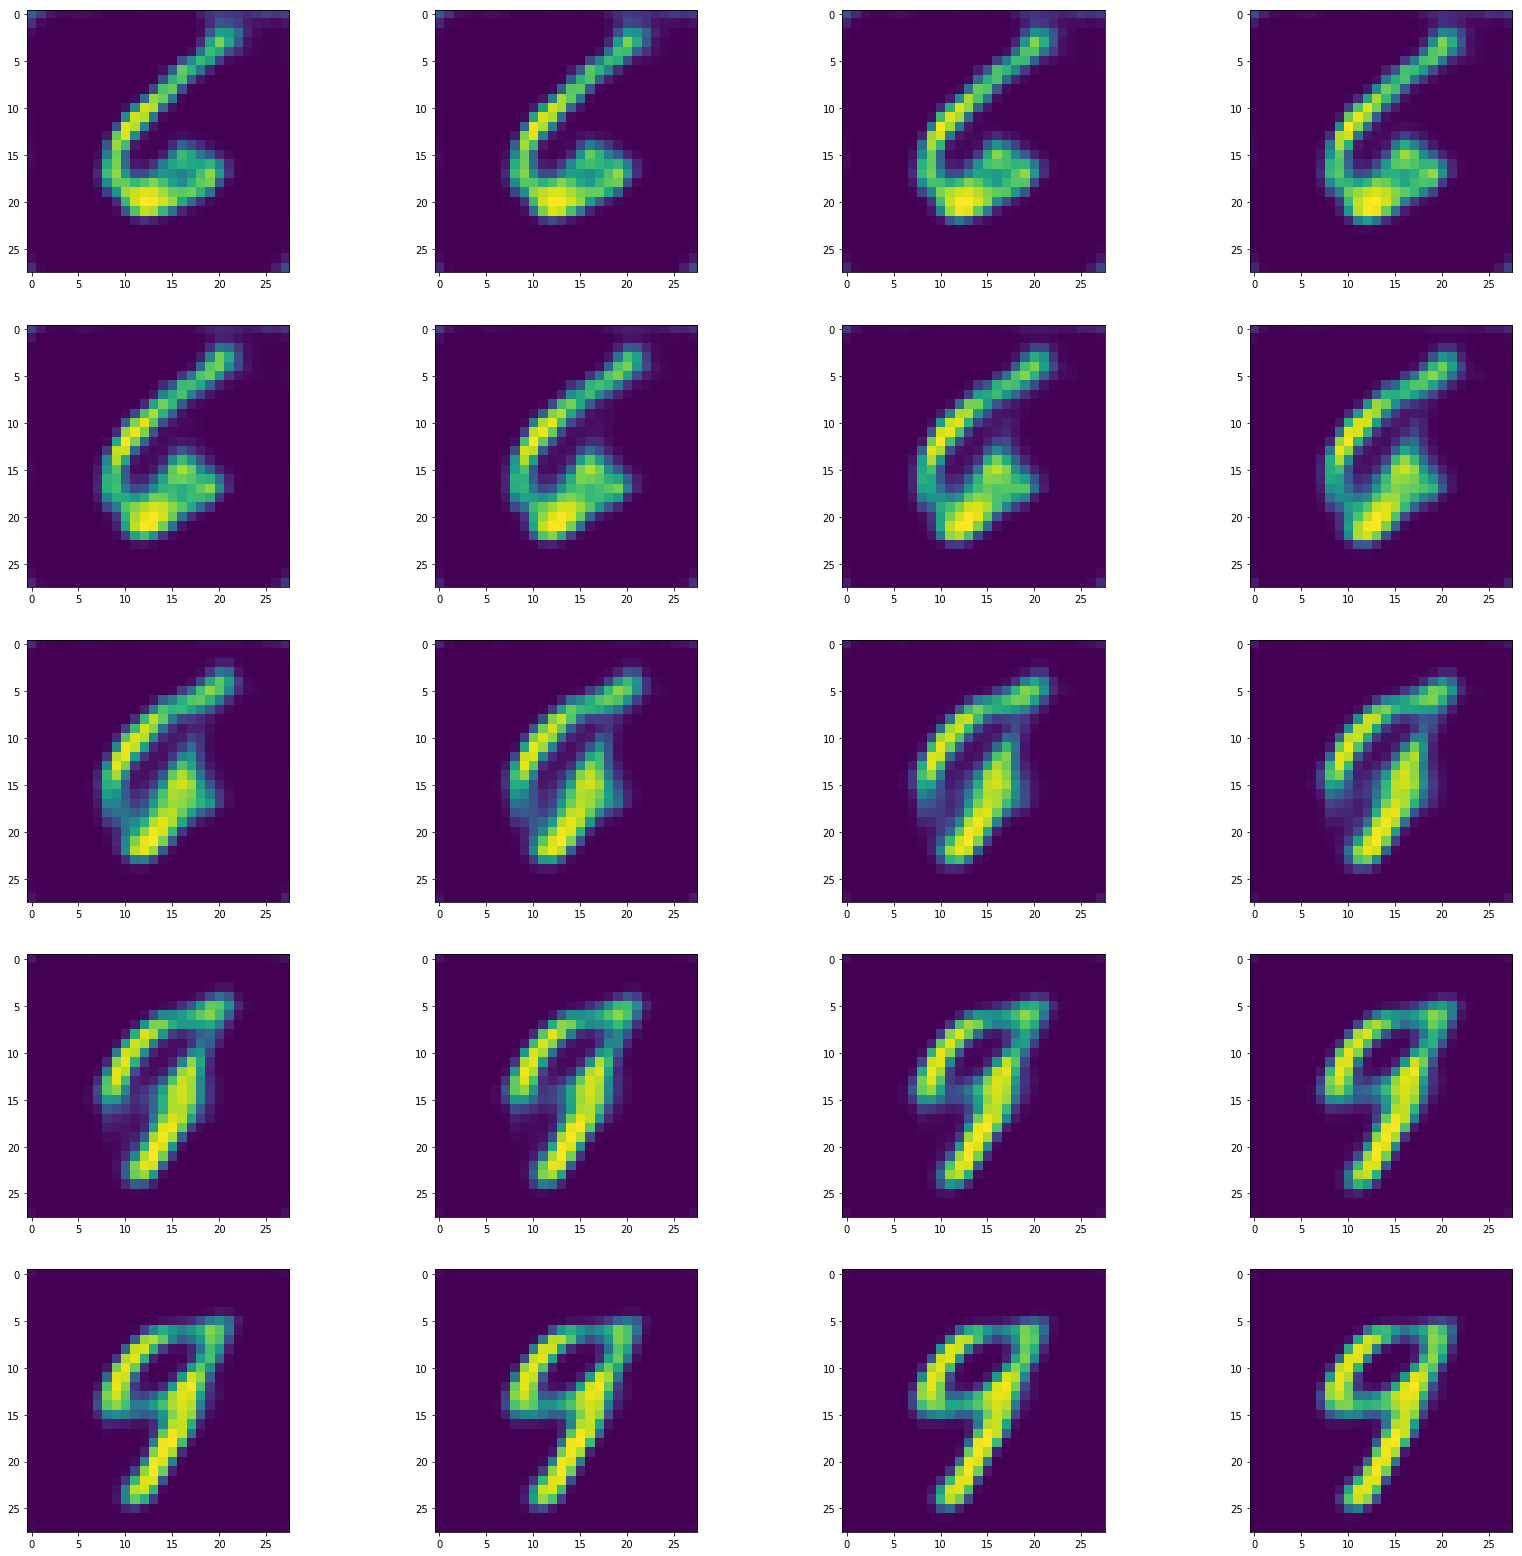

In [32]:
fig=plt.figure(figsize=(28, 28))
columns = 4
rows = 5
for i in range(1, columns*rows +1):
    img = all_recons[i-1].detach().numpy().reshape(28, 28)
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
plt.show()